自己模仿实现的神经网络模型，并实现分类

In [55]:
# coding = utf-8
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib.pyplot as plt
import numpy as np

第一步，生成数据，生成数据图表

In [56]:
# 使用的是sklearn中的数据，使用make_moons方法可以生成
x, y = sklearn.datasets.make_moons(n_samples = 1000, noise = 0.15)

然后将数据以图表的形式画出来

In [57]:
fig = plt.figure(figsize = (9, 6))
plt.scatter(x[:,0], x[:,1], c = y)
plt.title("original data")

先使用逻辑回归对数据进行划分，试试效果

In [58]:
lr = sklearn.linear_model.LogisticRegressionCV()
lr.fit(x, y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

将预测的效果以图表的形式展示

In [59]:
def show_linear_prediction(pred_func):
    #计算出横坐标的min和max以及纵坐标的min和max
    x_min, x_max = x[:,0].min() - 0.5, x[:,0].max() + 0.5
    y_min, y_max = x[:,1].min() - 0.5, x[:,1].max() + 0.5
    #步长
    h = 0.02
#     print(np.arange(x_min, x_max, h))
#     print(np.arange(y_min, y_max, h))
    #np.arrange(x_min, x_max, h)生成以h为步长，从x_min到x_max的一维数组
    #np.meshgrid()根据x向量和y向量生成网格矩阵
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    #pred_func=lamda x: lr.predic(x)
#     print(np.c_[xx.ravel(), yy.ravel()])
    z = pred_func(np.c_[xx.ravel(), yy.ravel()]);
    z = z.reshape(xx.shape);
    fig = plt.figure(figsize=(9, 6))
    #绘制登高线图
    #绘制登高线图需要生成栅格，即np.meshgrid()生成的数据
    plt.contourf(xx, yy, z, cmap=plt.cm.Spectral)
    plt.scatter(x[:, 0], x[:, 1], c=y)

In [60]:
# lr.predict(x)
show_linear_prediction(lambda x : lr.predict(x))
plt.title("logistic regression")

第二步，构建神经网络结构
构建三层神经网络模型，前馈神经网络
确定损失函数为交叉熵损失函数
然后使用批量梯度下降法求解参数
用反向传播方式更新参数
隐层激活函数为tanh函数，输出层激活函数为softmax函数

In [61]:
#初始化一些相关参数,训练样本个数，输入特征维度，输出特征维度
num_examples = len(x)
nn_input_dim = 2
nn_output_dim = 2

#学习率，正则项系数
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength

In [62]:
#首先实现损失函数
def loss_func(model):
    w1, b1, w2, b2 = model['w1'], model['b1'], model['w2'], model['b2']
    #前向计算预测值
    z1 = x.dot(w1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(w2) + b2
    exp_scores = np.exp(z2)
    softmax = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    #计算损失
#     print(softmax[[0, 1], [0]])
#     print(softmax[range(10), [1, 1, 0, 0, 0, 0, 0, 0, 0, 1]])
    #softmax[range(num_examples), y]
    #range(num_examples)表示数组下标
    #y表示根据y对应的值取这些元素中的数组下标为y[i]的值
    
    #这里是根据交叉熵的公式计算的，交叉熵的公式为:sum(yi*logy+(1-yi)*log(1-yi))
    correct_logy = - np.log(softmax[range(num_examples), y])
    
    loss = np.sum(correct_logy)
    data_loss = loss + reg_lambda / 2 * (np.sum(np.square(w1)) + np.sum(np.square(w2)))
    return 1.0 / num_examples * data_loss
# loss_func({'w1' : 1, 'b1' : 1, 'w2' : 1, 'b2' : 1})

In [63]:
#预测方法，根据给定的参数
def predict(model, x):
    w1, b1, w2, b2 = model['w1'], model['b1'], model['w2'], model['b2']
    
    z1 = x.dot(w1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(w2) + b2
    exp_scores = np.exp(z2)
    softmax = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    return np.argmax(softmax, axis=1)

第三步，构建和训练神经网络

In [64]:
#nn_hdim隐层神经元个数
#num_passes梯度下降法次数
#print_loss是否打印训练后的损失函数
def build_model(nn_hdim, num_passes = 20000, print_loss = False):
    #随机初始化学习参数
    np.random.seed(0)
    #np.random.randn生成正态分布的数据，维度为nn_input_dim和nn_hdim
    w1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    #np.zeros生成0np数组，包含两个元素，所以是二维的，第一个参数为1，表示第一维包含1个元素，第二个参数为nn_hdim，
    #表示每个第二维元素包含nn_hdim个元素
    b1 = np.zeros((1, nn_hdim))
    w2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))
    
    #记录模型的参数
    model = {}
    #梯度下降法开始训练模型，迭代次数不超过num_passes
    for i in range(num_passes):
        #前向传播计算结果
        z1 = x.dot(w1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(w2) + b2
        exp_scores = np.exp(z2)
        softmax = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        #反向传播更新参数，根据计算出来的结果公式
        delta3 = softmax
        delta3[range(num_examples), y] -= 1
        dw2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(w2.T) * (1 - np.power(a1, 2))
        dw1 = np.dot(x.T, delta2)
        db1 = np.sum(delta2, axis=0)
        
        #添加正则项参数
        dw2 += reg_lambda * w2
        dw1 += reg_lambda * w1
        
        #更新参数
        w2 += -epsilon * dw2
        w1 += -epsilon * dw1
        b2 += -epsilon * db2
        b1 += -epsilon * db1
        
        model = {'w2' : w2, 'w1' : w1, 'b2' : b2, 'b1' : b1}
        
        #打印损失
        if print_loss and i % 1000 == 0:
            print("loss after iter {}:{}".format(i, loss_func(model)))
        
    return model

第四步，测试结果，验证精确度

In [65]:
#构建一个3个隐层神经元的神经网络模型
num = 5
model = build_model(num, print_loss=True)

#打印预测输出的结果
show_linear_prediction(lambda x : predict(model, x))
plt.title("Decision Boundary for hidden layer size {}".format(num))

loss after iter 0:3.115494177215339
loss after iter 1000:0.9111609560827977
loss after iter 2000:2.912832532565274
loss after iter 3000:2.3009758615503433
loss after iter 4000:0.8656155119792234
loss after iter 5000:1.617319603080012
loss after iter 6000:1.317412442147166
loss after iter 7000:1.5969337687818155
loss after iter 8000:0.8507875108882658
loss after iter 9000:1.0951612641154347
loss after iter 10000:0.7790272896418029
loss after iter 11000:1.6715739049568834
loss after iter 12000:0.3924392499397122
loss after iter 13000:0.9923411084697716
loss after iter 14000:0.8067252191171012
loss after iter 15000:5.233916766542344
loss after iter 16000:0.3957050818345551
loss after iter 17000:1.5544538073026521
loss after iter 18000:0.8562964543853824
loss after iter 19000:0.996265923772452


第五步，修改参数后观察神经网络的预测效果

i:0,nn_hid_num:1
i:1,nn_hid_num:5
i:2,nn_hid_num:10


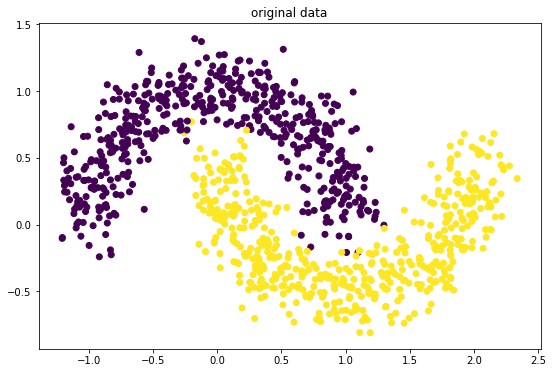

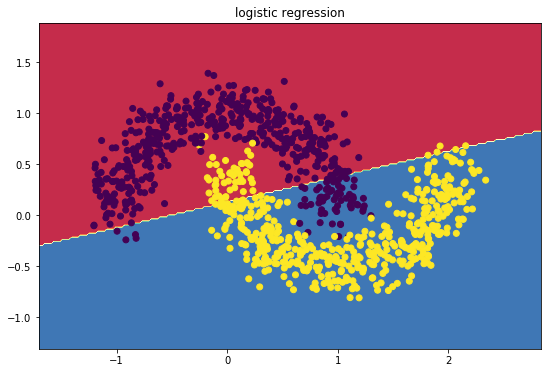

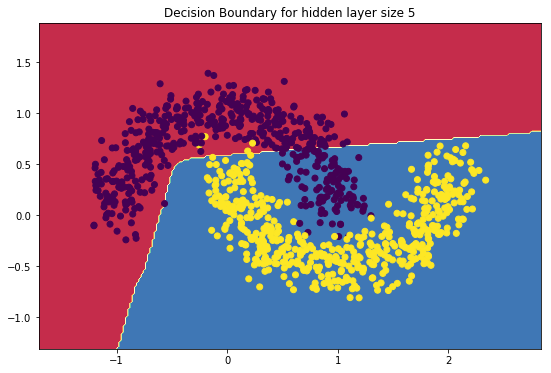

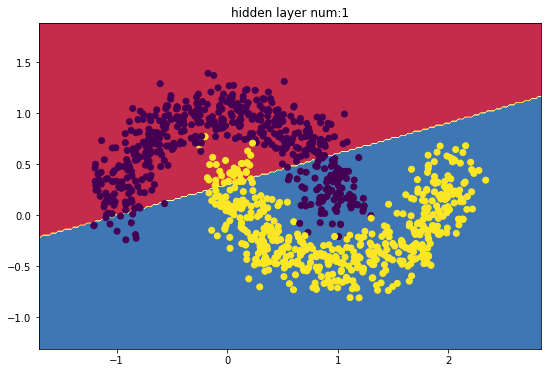

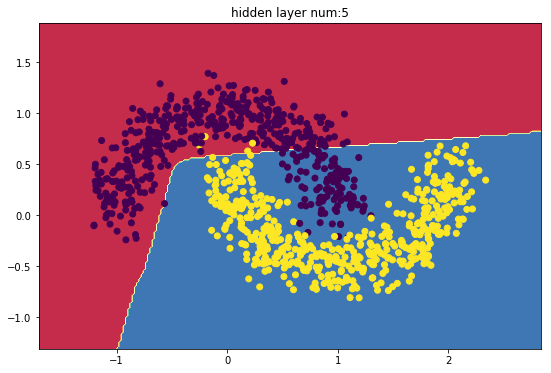

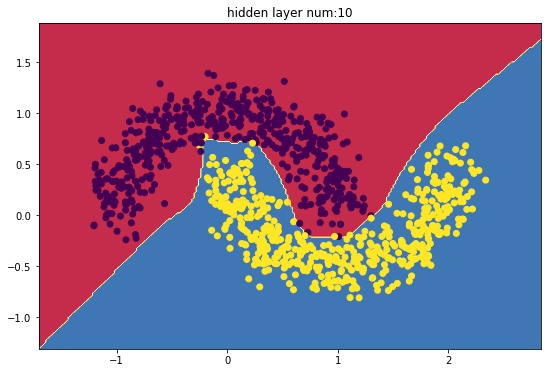

In [66]:
#修改隐层神经元的个数观察结果
hidden_layer_dim = [1, 5, 10]
for i, nn_hid_num in enumerate(hidden_layer_dim):
    print("i:{},nn_hid_num:{}".format(i, nn_hid_num))
    model = build_model(nn_hid_num)
    show_linear_prediction(lambda x : predict(model, x))
    plt.title("hidden layer num:{}".format(nn_hid_num))
plt.show()